## AUGMENTATION DATASET IMAGE CLASSIFICATION WITH RESNET50

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [54]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 31 19:56:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import needed library

In [55]:
!pip install -q efficientnet_pytorch

In [56]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import time
import re, gc
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image, ImageEnhance, ImageFilter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from collections import OrderedDict
import torch

# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam, lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler,  WeightedRandomSampler
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms, models
from efficientnet_pytorch import EfficientNet

import albumentations

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(" Device is {}".format(device))

 Device is cuda:0


In [58]:
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks


In [59]:
path = os.path.abspath('/content/drive/MyDrive/Colab Notebooks')
os.chdir(path)
print(path)

/content/drive/MyDrive/Colab Notebooks


In [60]:
# BASE_PATH = 'jpeg/train'
# print(BASE_PATH)

### Configuration variables

In [61]:
WIDTH = 224
HEIGHT = 224
INPUT_SIZE = 224
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
FOLDS = 10
SEED = 12321
VERBOSE_STEP = 1
BEST_AUC = 0

MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
MODEL_NAME = "resnet"
NUM_CLASSES = 2

### Helper Functions

In [62]:
# Seed everything
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [63]:
class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [64]:
def get_sample_from_df(sample,n):
    for i in list(range(n,0, -1)):
        if len(sample)>=i:
            return sample.sample(n=i, random_state=SEED).index[:i]   
    return [];


def sample_by_patient(dataset,num_sample=1):
  """ Get patient id as category.
   Prepare two datasets:
   for each patient_id
       select get records
         if malignant
           sample num_sample
         elif benign
           sample num_sample"""
  unique_patient_id = dataset.patient_id.cat.categories
  malignant_df = dataset[dataset['target'] == 1]
  benign_df = dataset[dataset['target'] == 0]
  sample_indices = []
  #samples per patient
  for  patient_id in unique_patient_id:
      patient_sample = malignant_df[malignant_df['patient_id']==patient_id]
      if len(patient_sample):
          sample_indices.extend(get_sample_from_df(patient_sample,num_sample))
      else:
          patient_sample = benign_df[benign_df['patient_id']==patient_id]
          sample_indices.extend(get_sample_from_df(patient_sample,num_sample))

  return dataset.loc[sample_indices]

def perform_sampling(dataset,sampling_type="", patient_group_sample=1):
  """function to perform sampling based on
     the sampling type provided.
     Return train, test dataset
  """
  train = None
  test = None
  if sampling_type=="PATIENT_GROUP":
    sample=sample_by_patient(dataset,patient_group_sample)
    train, test = train_test_split(sample, test_size=0.2, shuffle=True, random_state=SEED)
  else:
    # default train_test split by 8:2
    train, test = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=SEED)

  return train,test;

### Dataset

In [65]:
class Lesion_Dataset(Dataset):
    def __init__(self, img_data,img_path=None,resize=True, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.resize = resize
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join("jpeg",self.img_data.loc[index, 'images'])
        image = Image.open(img_name)      
        label = torch.tensor(self.img_data.loc[index, 'target'],dtype=torch.long)
        if self.resize:
            image = image.resize(
                (WIDTH, HEIGHT), resample=Image.BILINEAR
            )
        image = np.array(image)
        
        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            'image': torch.tensor(image, dtype=torch.float),
            'targets': label,
        }

### Load the data

We load the train.csv file. 

In [66]:
train_df = pd.read_csv(os.path.join(path,"aug_train_sample.csv"))
train_df.head()

,image_name,benign_malignant,target,images
0,aug/AUG_ISIC_7056748,benign,0,aug/AUG_ISIC_7056748.jpg
1,aug/AUG_ISIC_0927854,benign,0,aug/AUG_ISIC_0927854.jpg
2,aug/AUG_ISIC_0034292,benign,0,aug/AUG_ISIC_0034292.jpg
3,aug/AUG_ISIC_0030688,benign,0,aug/AUG_ISIC_0030688.jpg
4,aug/AUG_ISIC_0031478,benign,0,aug/AUG_ISIC_0031478.jpg


#### Preprocessing

In [67]:
print("The number of rows and columne in train.csv: {}".format(train_df.shape))
print(train_df.columns)
print("\nDATA TYPES\n")
print(train_df.dtypes)
print("\n=================================================\n")
print("\nCOLUMN COUNT\n")
print(train_df.count())
print("\nNULL COUNT\n")
print(train_df.isnull().sum())
# train_df.dropna(axis=0, inplace=True)

The number of rows and columne in train.csv: (8800, 4)
Index(['image_name', 'benign_malignant', 'target', 'images'], dtype='object')

DATA TYPES

image_name          object
benign_malignant    object
target               int64
images              object
dtype: object



COLUMN COUNT

image_name          8800
benign_malignant    8800
target              8800
images              8800
dtype: int64

NULL COUNT

image_name          0
benign_malignant    0
target              0
images              0
dtype: int64


In [68]:
# Covert columns to categorical type. 
train_df = train_df.astype({'benign_malignant':'category',
                            'target':'category'})

In [69]:
print("The number of rows and columne in train.csv: {}".format(train_df.shape))

The number of rows and columne in train.csv: (8800, 4)


#### Generating folds

In [70]:
kf = KFold(FOLDS, random_state=SEED, shuffle=True)
df = train_df.sample(frac=1).reset_index(drop=True)

for f, (_, val_index) in enumerate(kf.split(df, df)):
    df.loc[val_index, 'kfold'] = f
    
print(df['kfold'].value_counts())

8.0    880
5.0    880
9.0    880
4.0    880
3.0    880
7.0    880
0.0    880
1.0    880
2.0    880
6.0    880
Name: kfold, dtype: int64


#### Deriving wieghts for sampler

In [71]:
def generate_weights(df):
    B = 0.5

    C = np.array([B, (1 - B)])*2
    ones = len(df.query('target == 1'))
    zeros = len(df.query('target == 0'))

    weightage_fn = {0: C[1]/zeros, 1: C[0]/ones}
    return [weightage_fn[target] for target in df.target]

### Transforms


In [72]:
train_transforms = albumentations.Compose([
    albumentations.ShiftScaleRotate(p=0.9),
    albumentations.CLAHE(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.9),
    albumentations.Normalize(mean=MEAN, std=STD, always_apply=True)
])

test_transforms = albumentations.Compose([
    albumentations.Normalize(mean=MEAN, std=STD, always_apply=True)
])

### Model definitions

In [73]:
class EfficientModel(nn.Module):
    def __init__(self):
        super(EfficientModel, self).__init__()
        
        self.encoder = EfficientNet.from_pretrained("efficientnet-b1")
        self.dropout = nn.Dropout(0.3)
        self.head = nn.Sequential(nn.Linear(1280, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, 1),
                                  nn.Sigmoid())
        for param in self.head.parameters():
                param.requires_grad = True
    
    def forward(self, image):
        batch_size, _, _, _ = image.shape
        
        x = self.encoder.extract_features(image)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        
        x = self.dropout(x)
        logit = self.head(x)
        
        return logit


class ConvnextModel(nn.Module):
    def __init__(self):
        super(ConvnextModel, self).__init__()
        self.model = timm.create_model('convnext_xlarge_384_in22ft1k', pretrained=True)
        self.classifier=nn.Sequential(nn.Linear(1000, 256),nn.ReLU(), nn.Linear(256,1),nn.Sigmoid())
        for param in self.model.parameters():
            param.requires_grad = False
    
        # Unfreeze the last stage
        for param in self.model.stages[3].parameters():
            param.requires_grad = True
    
    def forward(self, x):
        x = self.model.forward_features(x)
        x = self.model.head(x)
        x = self.classifier(x)
        return x

# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
      
    if model_name == "efficientnet":
        """ Efficient Net B1 modified """
        model_ft = EfficientModel()
        input_size =224
    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 1),
                                    nn.Sigmoid())
        for param in model_ft.fc.parameters():
                param.requires_grad = True
    
        input_size = 224

    elif model_name == "convnext":
          model_ft = ConvnextModel()
          
          input_size = 224        
    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

### Model Utils


In [74]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=None)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=None)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

def loss_fn(outputs, targets):
    return FocalLoss(logits=False)(outputs, targets)


def train_fn(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    
    losses = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for bi, d in enumerate(tk0):
        images = d['image']
        targets = d['targets']
        
        images = images.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.long)
        model.zero_grad()
        outputs = model(images)
        targets = targets.view(-1, 1).type_as(outputs)
        
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        
        losses.update(loss.item(), images.size(0))
        
        tk0.set_postfix(loss=losses.avg)
    return losses.avg

def eval_fn(data_loader, model, device):
    model.eval()
    
    losses = AverageMeter()
    final_preds = []
    
    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader))
        
        for bi, d in enumerate(tk0):
            images = d['image']
            targets = d['targets']

            images = images.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.long)
            model.zero_grad()
            outputs = model(images)
            targets = targets.view(-1, 1).type_as(outputs)   

            loss = loss_fn(outputs, targets)
            losses.update(loss.item(), images.size(0))
            
            final_preds.extend(outputs.cpu().detach().numpy().tolist())
        
    return losses.avg, final_preds

def run_fold(fold,best_auc):
    patience = 0
    feature_extract = False
    # Initialize the model for this run
    model_ft, input_size = initialize_model(MODEL_NAME, NUM_CLASSES, feature_extract, use_pretrained=True)
    # Define the device:
    device = torch.device('cuda:0')
    # Put the model on the device:
    model = model_ft.to(device)
    
    # Selecting fold
    train_df = df[df['kfold'] != fold].reset_index(drop=True)
    valid_df = df[df['kfold'] == fold].reset_index(drop=True)
    
    weights = generate_weights(train_df)
        
    # Loading data
     # Create the dataset
    train_dataset = Lesion_Dataset(train_df,True,train_transforms)
    valid_dataset = Lesion_Dataset(valid_df,True,test_transforms)

    train_sampler = WeightedRandomSampler(weights, len(train_df))

    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=TRAIN_BATCH_SIZE, 
        sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, 
        batch_size=VALID_BATCH_SIZE, 
        shuffle=False)
    
    # Optimizer and scheduler
    num_train_steps = int(len(train_df) / TRAIN_BATCH_SIZE * EPOCHS)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=num_train_steps,
        eta_min=1e-6
    )
    
    # Training loop
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_loader, model, optimizer, device=device, scheduler=scheduler)
        loss, y_pred = eval_fn(valid_loader, model, device=device)
        
        y_pred = np.array(y_pred)
        val_auc = roc_auc_score(valid_df['target'].values, y_pred)      
        print(f"Epoch {epoch}.. "
                f"Train loss: {train_loss:.3f}.. "
                f"Validation loss: {loss:.3f}.. "
                f"Validation auc: {val_auc:.3f}")
        if val_auc > best_auc:
            torch.save(model, 'resnet_aug_model.pth')
            print('Validation score improved ({} --> {}). Saving model!'.format(best_auc, val_auc))
            best_auc = val_auc
        else:
          patience = patience + 1

        if patience >= 1:
          break;       

    return best_auc      

### Perform Training

In [75]:
BEST_AUC=0
for i in range(FOLDS):
    BEST_AUC=run_fold(i,BEST_AUC)
    #Validation score improved (0.9529613039691427 --> 0.9545694918513533). Saving model!

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0.. Train loss: 0.125.. Validation loss: 0.074.. Validation auc: 0.817
Validation score improved (0 --> 0.8167373914740025). Saving model!


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1.. Train loss: 0.073.. Validation loss: 0.080.. Validation auc: 0.859
Validation score improved (0.8167373914740025 --> 0.8588247488049947). Saving model!


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2.. Train loss: 0.037.. Validation loss: 0.013.. Validation auc: 0.958
Validation score improved (0.8588247488049947 --> 0.958235781874939). Saving model!


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3.. Train loss: 0.004.. Validation loss: 0.001.. Validation auc: 0.997
Validation score improved (0.958235781874939 --> 0.9973234318603064). Saving model!


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4.. Train loss: 0.001.. Validation loss: 0.001.. Validation auc: 0.998
Validation score improved (0.9973234318603064 --> 0.9979940981367672). Saving model!


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0.. Train loss: 0.136.. Validation loss: 0.242.. Validation auc: 0.786


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0.. Train loss: 0.119.. Validation loss: 0.106.. Validation auc: 0.736


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0.. Train loss: 0.153.. Validation loss: 0.169.. Validation auc: 0.507


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0.. Train loss: 0.128.. Validation loss: 0.104.. Validation auc: 0.740


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0.. Train loss: 0.117.. Validation loss: 0.267.. Validation auc: 0.799


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0.. Train loss: 0.148.. Validation loss: 0.149.. Validation auc: 0.661


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0.. Train loss: 0.126.. Validation loss: 0.098.. Validation auc: 0.788


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0.. Train loss: 0.122.. Validation loss: 0.139.. Validation auc: 0.833


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 0.. Train loss: 0.152.. Validation loss: 0.150.. Validation auc: 0.735


### Test the model

In [76]:
test = pd.read_csv(os.path.join(path,"aug_test_sample.csv"))
test.head()

,image_name,benign_malignant,target,images
0,aug/AUG_ISIC_0031542,malignant,1,aug/AUG_ISIC_0031542.jpg
1,aug/AUG_ISIC_0033674,benign,0,aug/AUG_ISIC_0033674.jpg
2,aug/AUG_ISIC_0031240,benign,0,aug/AUG_ISIC_0031240.jpg
3,aug/AUG_ISIC_7658133,benign,0,aug/AUG_ISIC_7658133.jpg
4,aug/AUG_ISIC_0033463,benign,0,aug/AUG_ISIC_0033463.jpg


In [77]:
def predict(data_loader, model, device):
    model.eval()
    classes  = ("benign", "malignant")
    final_preds = []
    labels = []
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    
    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader))
        
        for bi, d in enumerate(tk0):
            images = d['image']
            
            images = images.to(device, dtype=torch.float)
            targets = d['targets'].to(device, dtype=torch.long)

            outputs = model(images)
            # targets=targets.view(-1, 1).type_as(outputs)
            y_probs = outputs.squeeze(-1).cpu().detach().numpy()
            # _, predictions = torch.max(outputs, 1)
            predictions = y_probs > 0.5
            predictions = predictions.astype(int)
            targets = targets.data.cpu().numpy()
            for label, prediction in zip(targets, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1          
            final_preds.extend(y_probs.tolist())
            labels.extend(targets.tolist())
    return correct_pred, total_pred, labels, final_preds

test_df = test.reset_index(drop=True)
test_dataset = Lesion_Dataset(test_df,True,test_transforms)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=VALID_BATCH_SIZE, 
    shuffle=False
)

In [78]:
model = torch.load('resnet_aug_model.pth')

In [79]:
test_correct_pred, test_total_pred, test_y_true, test_y_preds = predict(test_loader, model, device)

  0%|          | 0/69 [00:00<?, ?it/s]

In [80]:
test_correct_pred

{'benign': 1504, 'malignant': 653}

In [81]:
test_total_pred

{'benign': 1526, 'malignant': 674}

In [82]:
print(np.array([test_y_true, test_y_preds]))

[[1.         0.         0.         ... 1.         1.         0.        ]
 [0.99208575 0.06492733 0.06230615 ... 0.99037266 0.96895087 0.0405033 ]]


In [83]:
test_preds = np.array(test_y_preds) > 0.5
test_preds=test_preds.tolist()

## Evaluating the model performance


In [84]:
classes  = ("benign", "malignant")

In [85]:
#print accuracy for each class
for classname, correct_count in test_correct_pred.items():
    print(classname,correct_count)
    accuracy = 0 if correct_count == 0 else 100 * float(correct_count) / test_total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

benign 1504
Accuracy for class: benign is 98.6 %
malignant 653
Accuracy for class: malignant is 96.9 %


## Confusion matrix

In [86]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_y_true,test_preds)
print(cf_matrix)

[[1504   22]
 [  21  653]]


In [87]:
np.sum(cf_matrix,axis=0)

array([1525,  675])

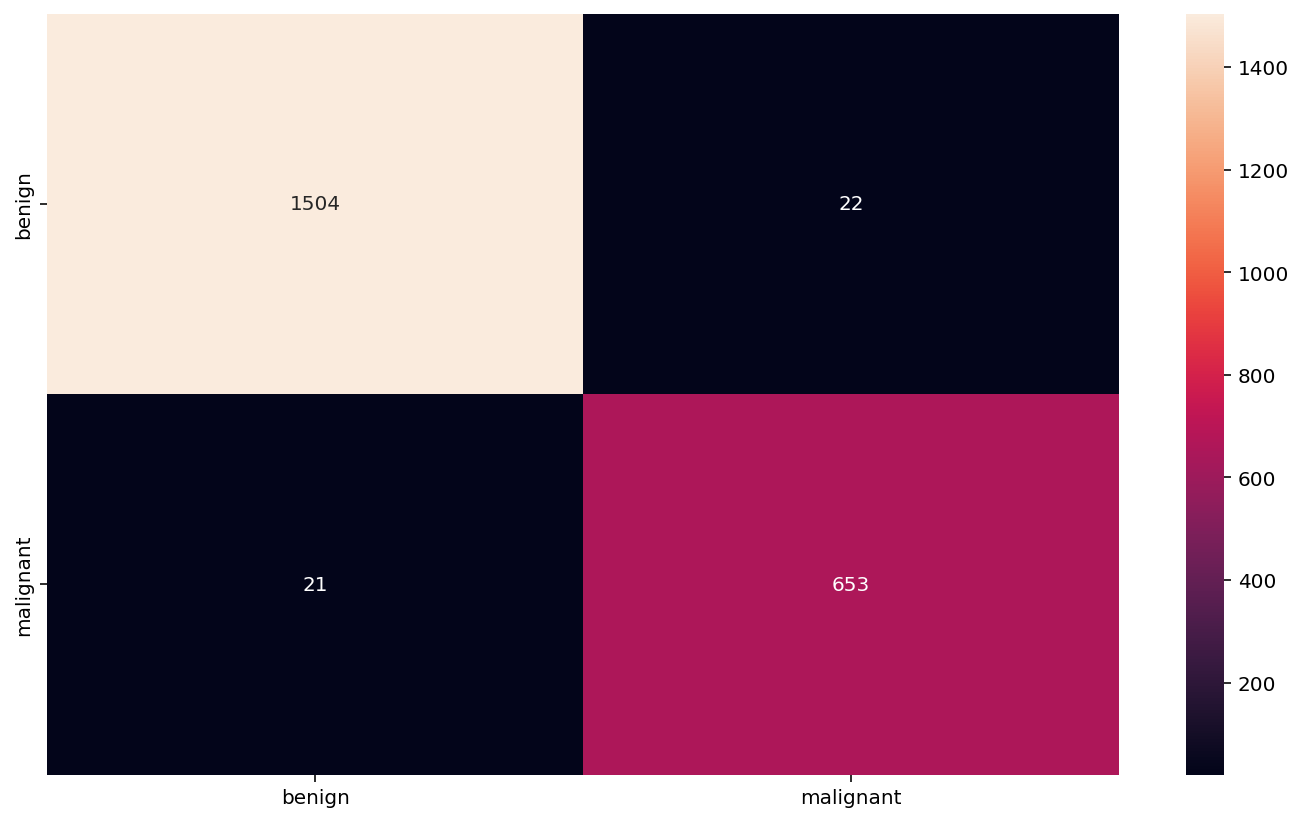

In [88]:
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
                     
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

## Evaluation metrics
1. recall
2. precision
3. PR Curve
4. F1 score
6. Accuracy

In [89]:
# Calculate specificity tn / (tn+fp)
def calculate_specificity(conf_matrix):
   return cf_matrix[0,0]/np.sum(cf_matrix,axis=0)[0]


In [90]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y_true, test_preds)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_y_true, test_preds)
print('Precision: %f' % precision)
# recall or sensitivity: tp / (tp + fn)
recall = recall_score(test_y_true, test_preds)
print('recall or sensitivity: %f' % recall)
# specificity
specificity = calculate_specificity(cf_matrix)
print('specificity: %f' % specificity)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y_true, test_preds)
print('F1 score: %f' % f1)

Accuracy: 0.980455
Precision: 0.967407
recall or sensitivity: 0.968843
specificity: 0.986230
F1 score: 0.968125


In [91]:
# y_2_prob_2=np.array(y_2_prob)
# y_2_prob_2.shape

In [92]:
# PR curve
from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(test_y_true, test_y_preds)

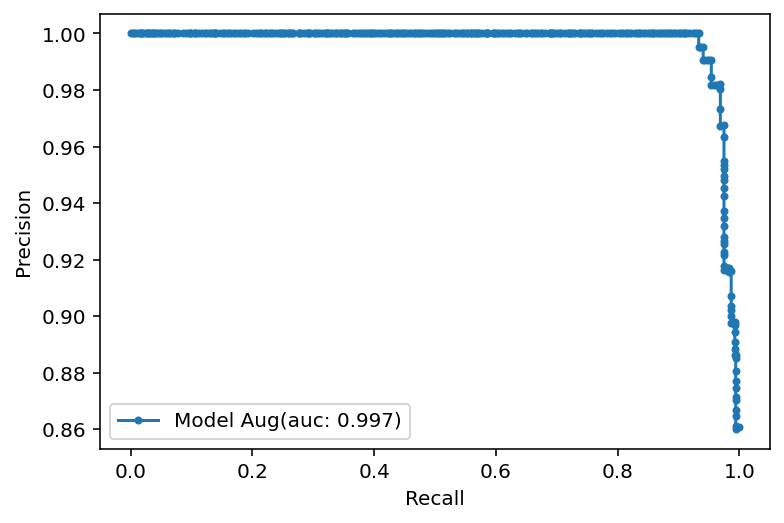

In [93]:
# calculate scores
lr_auc = auc(recall, precision)
# plot the precision-recall curves
plt.plot(recall, precision, marker='.', label='Model Aug(auc: %.3f)' %lr_auc)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()